# Importações

In [25]:
import os
from pyhdf.SD import SD, SDC
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Dados L3:

In [26]:
def idx_coord(lista_coor, coord):
    """ Função que retorna indice do valor da lista mais proximo ao valor passado """
    return (np.abs(lista_coor - (coord))).argmin()

In [27]:
def slice_variaveis(dado, lat_n, lat_s, lon_e, lon_w, variavel):
    """Retorna o valor da variável com corte de área a partir do HDF"""
    # Cria variaveis de lat e lon
    lat = dado.select('Latitude_Midpoint').get()[0]
    lon = dado.select('Longitude_Midpoint').get()[0]

    # Selecionando índices correspondentes aos pontos mais proximos ao intervalo dado
    idx_n_lat, idx_s_lat = idx_coord(lat, lat_n), idx_coord(lat, lat_s)
    idx_e_lon, idx_w_lon = idx_coord(lon, lon_e), idx_coord(lon, lon_w)

    dado = dado.select(variavel)[int(idx_s_lat):int(idx_n_lat) + 1,
                                 int(idx_w_lon):int(idx_e_lon) + 1]
    dado = dado.astype('float')
    dado[dado == -9999] = np.nan
    if 'Extinction_Coefficient_532_Mean' in variavel:
        dado[dado < 0] = np.nan
        dado[dado > 4] = np.nan
    elif 'AOD_Mean' in variavel:
        dado[dado < 0] = np.nan
        dado[dado > 5] = np.nan
    else:
        dado[dado < 0] = np.nan
        dado[dado > 32767] = np.nan
    return dado

In [28]:
def porc_passou_qc(dado):
    return (dado.size - np.count_nonzero(np.isnan(dado)))/dado.size

In [29]:
def med_espacial(dado):
    med_esp = np.nanmean(np.nanmean(dado, axis=0), axis=0)
    return med_esp

In [30]:
def med_estacao_det_tipo(dado):
    det_tipo = pd.concat(dado, axis=1).T
    det_tipo.index.rename(['mês', 'tipo'], inplace=True)
    
    # Criando indice com estação e ano
    det_tipo['Estacão_ano'] = ['INVERNO ' + x[:4] if 6 <= int(x[-2:]) <= 8
                               else 'PRIMAVERA ' + x[:4] if 9 <= int(x[-2:]) <= 11
                               else 'VERÃO ' + str(int(x[:4]) + 1) if x[-2:] == '12'
                               else 'VERÃO ' + x[:4] if int(x[-2:]) <= 2
                               else 'OUTONO ' + x[:4] for x in det_tipo.index.get_level_values(0)]
    det_tipo = det_tipo.set_index('Estacão_ano', append=True)

    # Excluir estações dos anos que não tem 3 meses para compor a média sazonal
    unique, counts = np.unique(det_tipo.groupby(
        level=[0, 2]).count().index.get_level_values(1), return_counts=True)
    meses_est = dict(zip(unique, counts))
    excluir = [mes for mes in meses_est.keys() if meses_est[mes] < 3]
    det_tipo.drop(excluir, level=2, axis=0, inplace=True)
    # Fazendo a média sazonal para cada ano
    det_tipo = det_tipo.groupby(level=[2, 1]).mean()
    return det_tipo.loc[(det_tipo != 0).any(axis=1)]

In [31]:
def med_estacao_uni(dado):
    dado = pd.DataFrame.from_dict(dado, orient='index')

    dado['Estacão_ano'] = ['INVERNO ' + x[:4] if 6 <= int(x[-2:]) <= 8
                           else 'PRIMAVERA ' + x[:4] if 9 <= int(x[-2:]) <= 11
                           else 'VERÃO ' + str(int(x[:4]) + 1) if x[-2:] == '12'
                           else 'VERÃO ' + x[:4] if int(x[-2:]) <= 2
                           else 'OUTONO ' + x[:4] for x in dado.index]
    dado = dado.set_index('Estacão_ano')

    # Verificando quais estações de cada ano contam com os 3 meses para compor a média sazonal do ano
    unique, counts = np.unique(dado.index, return_counts=True)
    meses_est = dict(zip(unique, counts))
    excluir = [mes for mes in meses_est.keys() if meses_est[mes] < 3]
    # Removendo dados das estações que não tem 3 meses para a média
    dado.drop(excluir, axis=0, inplace=True)
    return dado.groupby(level=[0]).mean()

In [32]:
def med_periodo_uni(dado):
    dados = dado.copy()
    return dados.groupby([dados.index.get_level_values(0).str[:-5]]).agg(['mean', 'std']).stack()

In [33]:
def med_periodo_det_tipo(dado):
    dados = dado.copy()
    media = dados.groupby([dados.index.get_level_values(
        0).str[:-5], dados.index.get_level_values(1)]).agg(['mean', 'std']).stack()
    return media.loc[(media != 0).any(axis=1)]

In [34]:
def anomalia_estacao(med_est, media_per):
    media_per = media_per.reorder_levels([1, 0], axis=1)
    media_per = media_per['mean']
    for estacao in media_per.columns:
        med_est[[col for col in med_est.columns if estacao in col]] = med_est[[
            col for col in med_est.columns if estacao in col]].sub(media_per[estacao], axis=0)
    return med_est

In [35]:
def anomalia_tipos(med_est, media_per):
    anom_dict = {}
    estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']
    media_per = media_per.reorder_levels([2, 0, 1], axis=1)
    media_per = media_per['mean']
    for estacao in estacoes:
        anom_dict[estacao] = med_est[[col for col in med_est.columns.unique(
            level=0) if estacao in col]].sub(media_per[estacao], axis=0)
    # return anom_dict
    return pd.concat(anom_dict, axis=1)

In [36]:
def med_periodo_uni(dado):
    dados = dado.copy()
    return dados.groupby([dados.index.get_level_values(0).str[:-5]]).agg(['mean', 'std']).stack()

In [37]:
def med_periodo_det_tipo(dado):
    dados = dado.copy()
    media = dados.groupby([dados.index.get_level_values(
        0).str[:-5], dados.index.get_level_values(1)]).agg(['mean', 'std']).stack()
    return media.loc[(media != 0).any(axis=1)]

In [38]:
def anomalia_estacao(med_est, media_per):
    media_per = media_per.reorder_levels([1, 0], axis=1)
    media_per = media_per['mean']
    #media_per = media_per.to_frame().T.mean()
    for estacao in media_per.columns:
        med_est[[col for col in med_est.columns if estacao in col]] = med_est[[
            col for col in med_est.columns if estacao in col]].sub(media_per[estacao], axis=0)
    return med_est

In [39]:
def anomalia_tipos(med_est, media_per):
    anom_dict = {}
    estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']
    media_per = media_per.reorder_levels([2, 0, 1], axis=1)
    media_per = media_per['mean']
    for estacao in estacoes:
        anom_dict[estacao] = med_est[[col for col in med_est.columns.unique(
            level=0) if estacao in col]].sub(media_per[estacao], axis=0)
    # return anom_dict
    return pd.concat(anom_dict, axis=1)

# Funções de Auxílio:

In [40]:
def fun_district(path):
    '''
        Não acho que seria interessante misturar os arquivos HDFs com outros arquivos,
    porém, do jeito que está configurada a minha organização das pastas, não há a necessidade
    de gerar outra entrada para dizer onde as imagens serão salvas.
    
        Essa função então, foi construida para cumprir esse propósito, a ideia aqui é
    reorganizar o caminho dos diretório para que as imagens sejam salvas de forma organizada.
    '''
    
    # Acrescentando um termo para gerar outro diretório:
    img_diretorio = path+'_img'
    
    # Caso a pasta não tenha sido criada previamente:
    if not os.path.exists(img_diretorio):
        os.mkdir(img_diretorio)
        
    return img_diretorio

In [41]:
def hdf_path(diretorio, faixa_ano=[]):
    '''
        Função que organiza a entrada, de modo que o código rode inicialmente
    '''
    if faixa_ano != type(list):
        faixa_ano = []

    hdf_files = []
    for filename in os.listdir(diretorio):
        if filename.endswith(".hdf"):
            ano_local = filename[51:55]
            if not faixa_ano or ano_local in faixa_ano:
                hdf_path = os.path.join(diretorio, filename)
                hdf_files.append(hdf_path)   
    return hdf_files

# Importando Arquivos:

In [42]:
# Definição do Diretório:
perg = input('Qual o diretório?\n')

if perg == 'lasa':
    path = r'C:\Users\amori\OneDrive\Documentos\LASA\Dados\L3_VFM(2006-2020)'
    
if perg == 'casa':
    path = r'D:\Estudo\LASA\Dados\Bahia\Download_L3'

Qual o diretório?
casa


In [43]:
# Inervalo de Tempo:
ano_inicial = input('Data de Inicio(Ano): ')
ano_final = input('Data de Final(Ano): ')

    
if ano_inicial == '':
    ano_inicial = '2006'
    
elif int(ano_inicial) < 2006:
    print('Não existe valores anteriores a 2006')

    
if ano_final == '':
    ano_final = '2020'
    
elif int(ano_final) > 2022:
    print('Não existe valores maiores que 2022')

hdf_files = hdf_path(path, [ano_inicial,ano_final])

Data de Inicio(Ano): 
Data de Final(Ano): 


In [44]:
# Definição da área:
cidade = input('Digite o nome cidade em questão:\n')

if cidade == '':
    cidade = 'Bahia'
# Áreas:
area = input('digite a Área (a1,a2,a3, a4 ou a5): ')

if area == 'a1':
    lon_w = -40
    lat_s = -15
    lon_e = -37
    lat_n = -11
    area = 1
    
elif area == 'a2':
    lon_w = -40
    lat_s = -11
    lon_e = -38.5
    lat_n = -9.25
    area = 2
    
elif area == 'a3':
    lon_w =  -41.5
    lat_s =  -11.5
    lon_e =  -40
    lat_n =  -10
    area = 3

elif area == 'a4':
    lon_w = -41.75
    lat_s = -14.5
    lon_e = -39.5
    lat_n = -11.5
    area = 4

elif area == 'a5':
    lon_w = -43
    lat_s = -14
    lon_e = -41
    lat_n = -11
    area = 5
    
else:
    print('Digitou alguma coisa errada ai my consagrated... :(')

Digite o nome cidade em questão:
bahia
digite a Área (a1,a2,a3, a4 ou a5): a1


# Análise e Classifição de Elemento:

In [45]:
#Nome das váriáveis de interesse
variaveis = ['Extinction_Coefficient_532_Mean', 'Extinction_Coefficient_532_Mean_Dust',
                 'Extinction_Coefficient_532_Mean_Elevated_Smoke', 'Extinction_Coefficient_532_Mean_Polluted_Dust',
                 'AOD_Mean', 'AOD_Mean_Dust', 'AOD_Mean_Elevated_Smoke', 'AOD_Mean_Polluted_Dust',
                 'Samples_Aerosol_Detected_Accepted', 'Aerosol_Type']

#Cria dicionário vazio
dados = {}

for variavel in variaveis:
    # Para cada variável cria um novo dicionário
    dados[variavel] = {}
    for file in hdf_files:
        #Abre cada arquivo listado
        dado = SD(file, SDC.READ)
        #Seleciona dados de cada variável fazendo corte de área
        dado = slice_variaveis(dado, lat_n , lat_s, lon_e, lon_w ,variavel)
        # Adicionar mês ao dicionário apenas quando 80% dos dados passam no CQ
        if porc_passou_qc(dado) >= 0.8:
            dado = med_espacial(dado)
            #Cria chave com valores de oara cada mês que passa no controle de qualidade 
            dados[variavel][file[-12:-5]] = dado

C:\Users\amori\AppData\Local\Temp\ipykernel_12132\3927049585.py:2: RuntimeWarning: Mean of empty slice
  med_esp = np.nanmean(np.nanmean(dado, axis=0), axis=0)


In [46]:
# Variáveis com apenas um perfil por mês ou um dado por mês
variaveis_uni = ['Extinction_Coefficient_532_Mean', 'Extinction_Coefficient_532_Mean_Dust',
                 'Extinction_Coefficient_532_Mean_Elevated_Smoke', 'Extinction_Coefficient_532_Mean_Polluted_Dust',
                 'AOD_Mean', 'AOD_Mean_Dust', 'AOD_Mean_Elevated_Smoke', 'AOD_Mean_Polluted_Dust',
                 'Samples_Aerosol_Detected_Accepted']

# Criando dicionário para salvar calculo das médias sazonais anuais
med_estacao = {}
# Transformando dict de array em dict de df
dados['Aerosol_Type'] = {chave: pd.DataFrame(valor, columns=['Marinho Limpo', 'Poeira',
                                                             'Poluição Continental/Fumaça',
                                                             'Continental Limpo', 'Poeira Poluída', 
                                                             'Fumaça Elevada', 'Poeira Marinha'])
                         for chave, valor in dados['Aerosol_Type'].items()}
for variavel in variaveis_uni:
    #Salvando df com as médias sazonais para cada ano de cada variável de perfil único na chave da variável 
    med_estacao[variavel] = med_estacao_uni(dados[variavel])

#Salvando df com médias sazonais para cada ano e tipo de aerossol na chave da variável de detecção de aerossóis por tipo 
med_estacao['Aerosol_Type'] = med_estacao_det_tipo(dados['Aerosol_Type'])

In [47]:
# Criando de dicionário para salvar médias sazonais do período
med_periodo = {}
for variavel in variaveis_uni:
    #Salvando df com as médias sazonais do período para cada variável de perfil único na chave da variável 
    med_periodo[variavel] = med_periodo_uni(med_estacao[variavel])
#Salvando df com médias sazonais do período para cada tipo de aerossol na chave da variável de detecção de aerossóis por tipo 
med_periodo['Aerosol_Type'] = med_periodo_det_tipo(med_estacao['Aerosol_Type'])

In [48]:
anomalia = {}
for variavel in variaveis_uni:
    anomalia[variavel] = anomalia_estacao(med_estacao[variavel].T, med_periodo[variavel].T)
anomalia['Aerosol_Type'] = anomalia_tipos(med_estacao['Aerosol_Type'].T, med_periodo['Aerosol_Type'].T)


    Gráfico de anomalisas:
    Essas são as anomalias das detecções de cada tipo de aerossol.



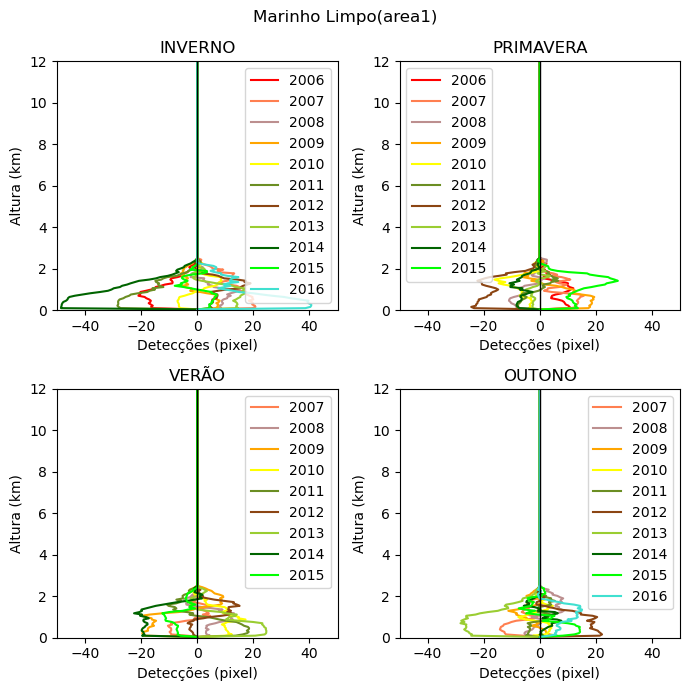

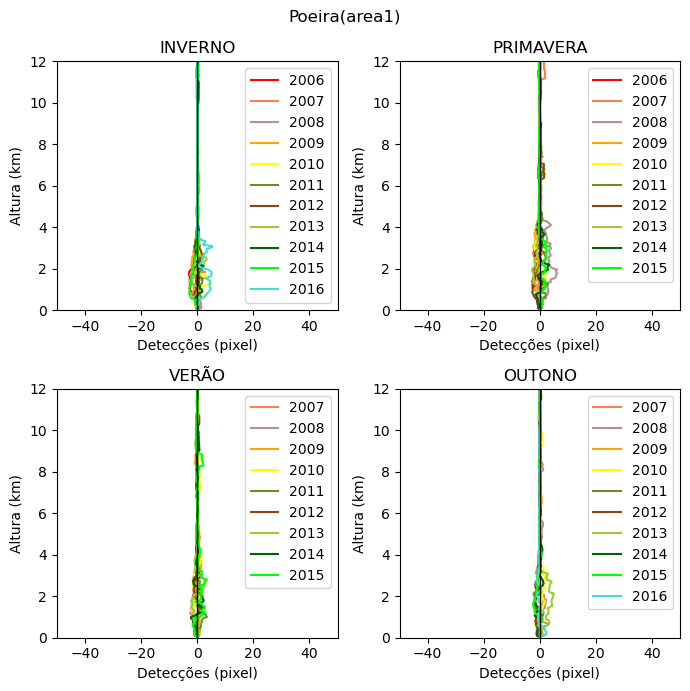

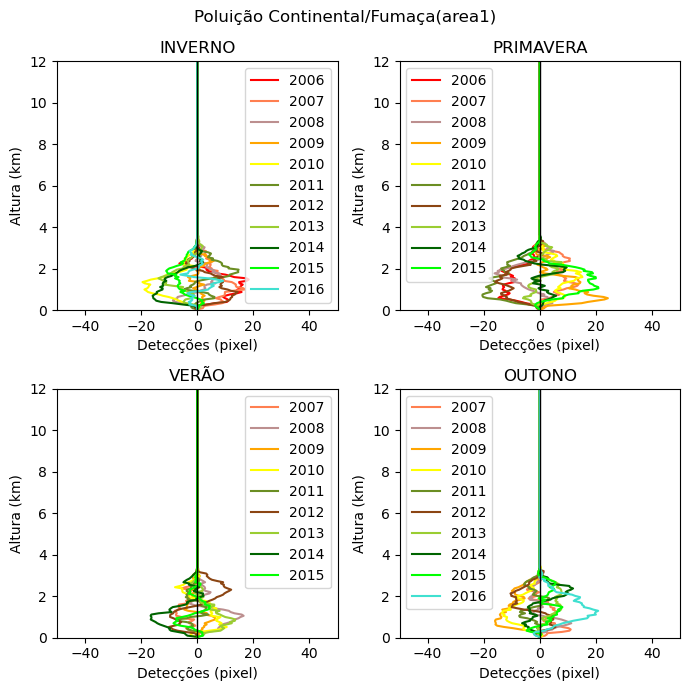

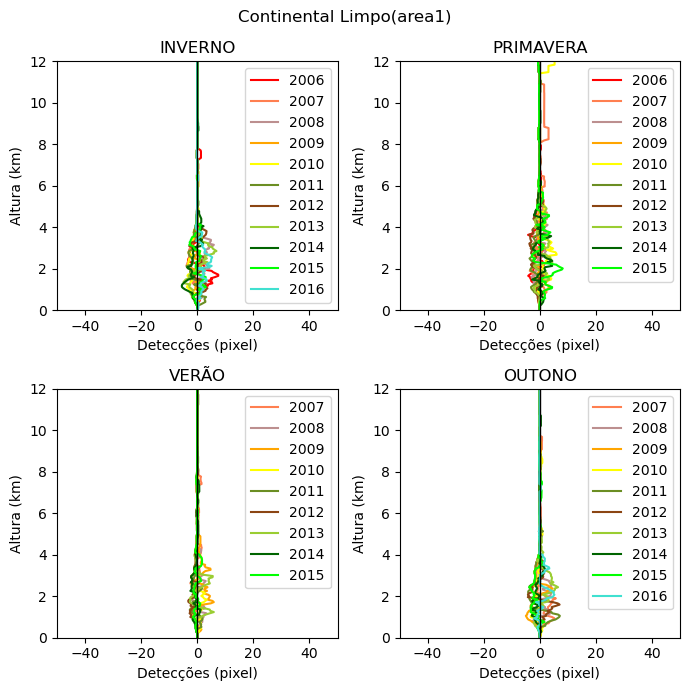

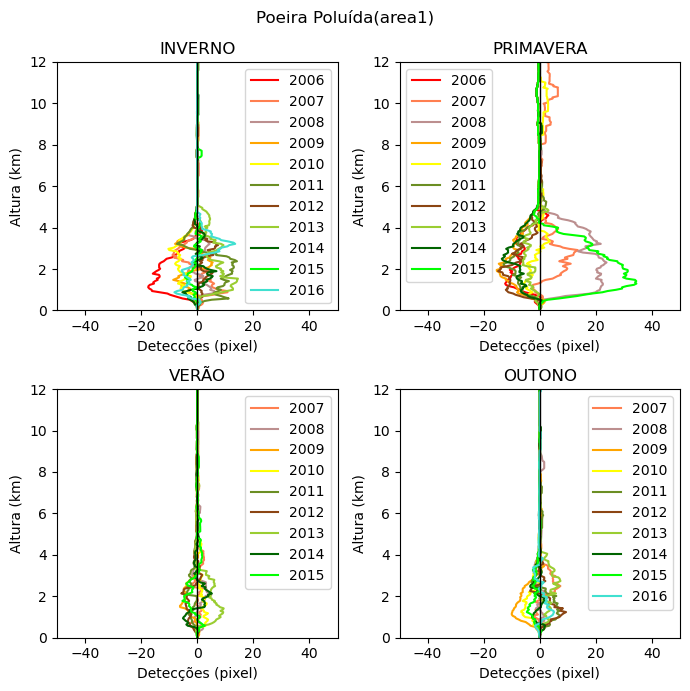

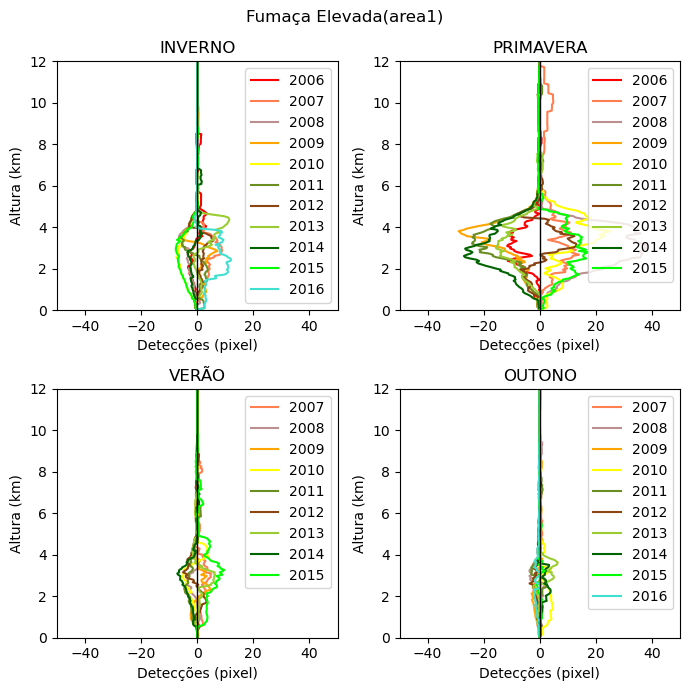

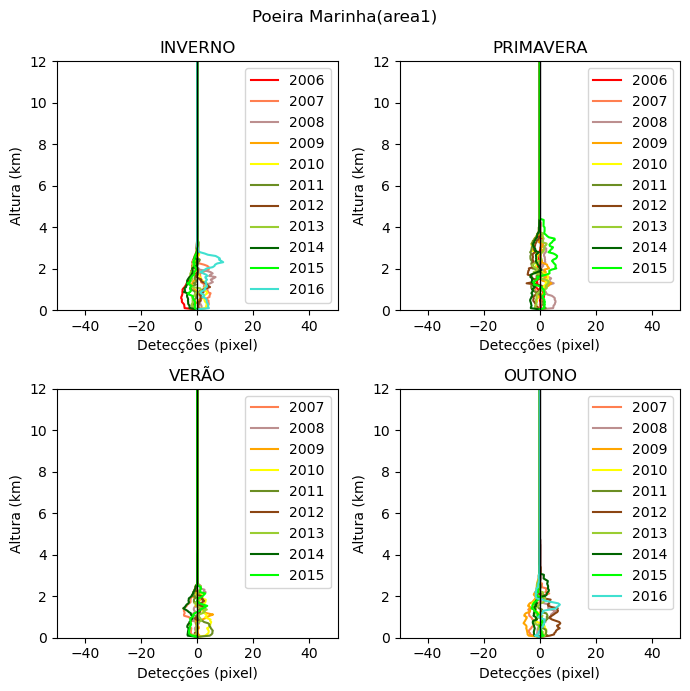

In [49]:
cores = {'2006': 'red', '2007': 'coral', '2008': 'rosybrown', '2009': 'orange',
         '2010': 'yellow', '2011': 'olivedrab', '2012': 'saddlebrown', '2013': 'yellowgreen',
         '2014': 'darkgreen', '2015': 'lime', '2016': 'turquoise', '2017': 'deepskyblue',
         '2018': 'slategrey', '2019': 'navy', '2020': 'rebeccapurple', '2021': 'fuchsia',
         '2022': 'deeppink'}

# Todos os tipos:
tipos = ['Marinho Limpo', 'Poeira', 'Poluição Continental/Fumaça',
         'Continental Limpo', 'Poeira Poluída', 'Fumaça Elevada', 'Poeira Marinha']


estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']
alt = SD(file, SDC.READ).select('Altitude_Midpoint').get()[0]

anom_tipo = anomalia['Aerosol_Type'].copy()
anom_tipo.columns = anom_tipo.columns.reorder_levels([2, 0, 1])
for tipo in tipos:
    try:
        fig, axs = plt.subplots(2, 2, figsize=(7, 7), facecolor='white')
        for estacao, ax in zip(estacoes, axs.flatten()):
            anos = anom_tipo[tipo][estacao].columns.unique(level=0)
            ax.set_title(estacao)
            for ano in anos:
                ax.plot(anom_tipo[tipo][estacao][ano], alt, color=cores[ano[-4:]])
    
            ax.axvline(color='black', linewidth=1)
            ax.set_ylim(0, 12)
            ax.set_xlim(-50,50)
            ax.set_xlabel('Detecções (pixel)', fontsize=10)
            ax.set_ylabel('Altura (km)', fontsize=10)
            ax.legend([x[-4:] for x in anos])
        fig.suptitle(tipo+f'(area{area})')
        fig.tight_layout()
        plt.savefig(fun_district(path) + cidade + '_anomalia_deteccao_tipo' +
                    tipo.replace(' ', '_').replace('/', '_')+f'(area{area})', bbox_inches='tight')
    except:
        print(f'Não tem a o aerossol do tipo {tipo}')
print('''
    Gráfico de anomalisas:
    Essas são as anomalias das detecções de cada tipo de aerossol.
''')

In [50]:
type(anomalia)

dict


    Anomalia do Coeficiente de Extinção:
    Total (Coeficiente de Extinção) - O total das anomalias do coeficiente de extinção. Note que as informações
    desse grafico do total são explicadas em outros gráficos separados para cada tipo de aerossol.
    
    Total (detecções) - Anomalia do total de detecções dos aerossois.



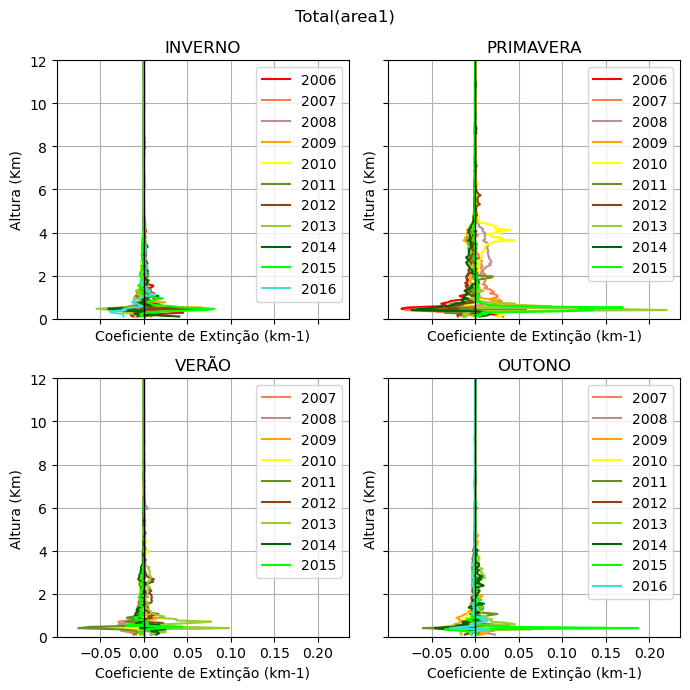

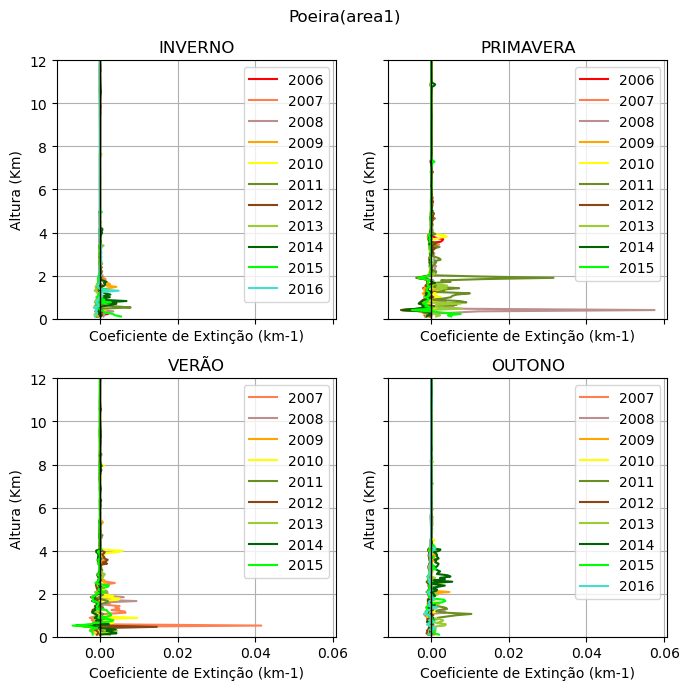

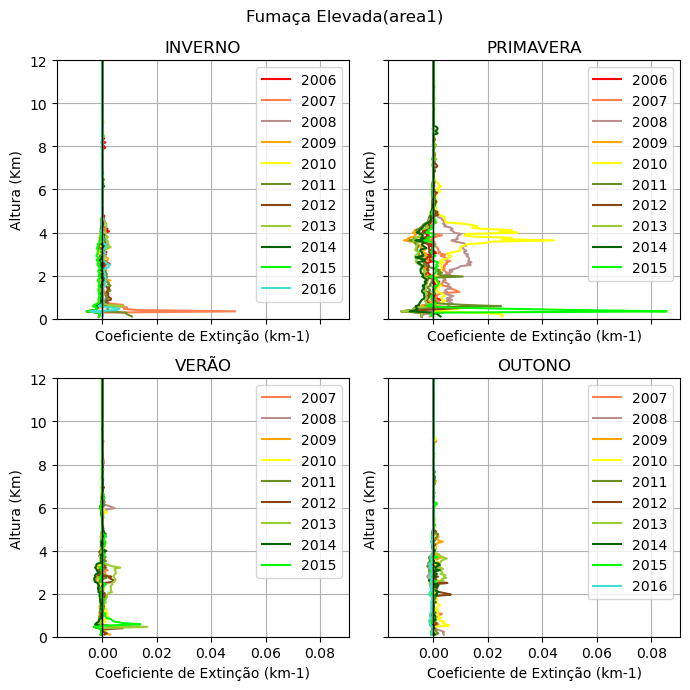

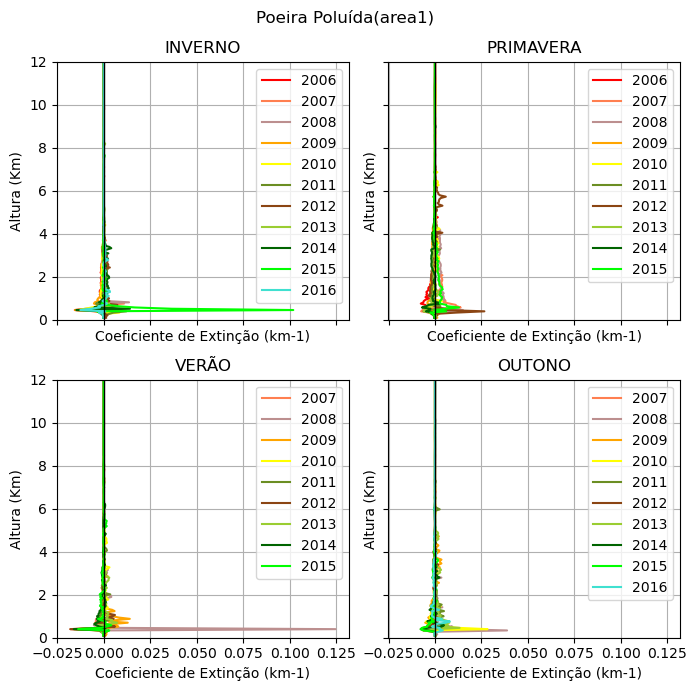

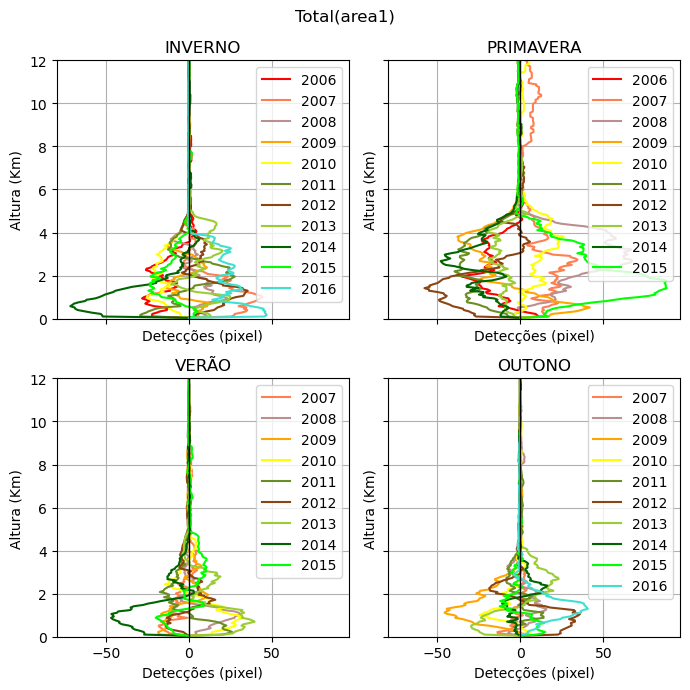

In [51]:
cores = {'2006': 'red', '2007': 'coral', '2008': 'rosybrown', '2009': 'orange',
         '2010': 'yellow', '2011': 'olivedrab', '2012': 'saddlebrown', '2013': 'yellowgreen',
         '2014': 'darkgreen', '2015': 'lime', '2016': 'turquoise', '2017': 'deepskyblue',
         '2018': 'slategrey', '2019': 'navy', '2020': 'rebeccapurple', '2021': 'fuchsia',
         '2022': 'deeppink'}
variaveis_uni_perfil = ['Extinction_Coefficient_532_Mean',
                        'Extinction_Coefficient_532_Mean_Dust',
                        'Extinction_Coefficient_532_Mean_Elevated_Smoke',
                        'Extinction_Coefficient_532_Mean_Polluted_Dust',
                        'Samples_Aerosol_Detected_Accepted']
nome_pt = ['Total','Poeira','Fumaça Elevada', 'Poeira Poluída', 'Total']

correspondencia_nome = dict(zip(variaveis_uni_perfil,nome_pt))

alt = SD(file, SDC.READ).select('Altitude_Midpoint').get()[0]
estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']
from matplotlib import pyplot as plt
for variavel in variaveis_uni_perfil:
    fig, axs = plt.subplots(2,2,figsize = (7,7), facecolor='white', sharex=True, sharey=True)
    for estacao,ax in zip(estacoes,axs.flatten()):
        anos = anomalia[variavel][[col for col in anomalia[variavel].columns if estacao in col]].columns
        for ano in anos:
            ax.plot(anomalia[variavel][ano], alt, color = cores[ano[-4:]])
        ax.legend([col[-4:] for col in anos if estacao in col])
        ax.set_title(estacao)
        ax.axvline(color = 'black',linewidth=1)
        ax.set_ylim(0,12)
        #ax.set_xlim(-0.5,0.5)
        ax.grid(True)
        ax.set_ylabel('Altura (Km)',fontsize= 10)   
        if 'Extinction_Coefficient' in variavel:
            ax.set_xlabel('Coeficiente de Extinção (km-1)', fontsize= 10)
        else:
            ax.set_xlabel('Detecções (pixel)', fontsize= 10)

    fig.suptitle(correspondencia_nome[variavel]+f'(area{area})')

    fig.tight_layout()
    plt.savefig(fun_district(path) + cidade + '_anomalia_'+variavel+f'(area{area})', bbox_inches='tight')
print('''
    Anomalia do Coeficiente de Extinção:
    Total (Coeficiente de Extinção) - O total das anomalias do coeficiente de extinção. Note que as informações
    desse grafico do total são explicadas em outros gráficos separados para cada tipo de aerossol.
    
    Total (detecções) - Anomalia do total de detecções dos aerossois.
''')

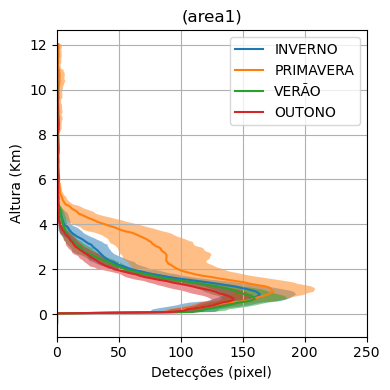


    Totais de detecções de aerossois em cada uma das estações do ano. 



In [52]:
# Perfil vertical do total de detecções de aerossóis troposféricos 
estacoes = ['INVERNO','PRIMAVERA','VERÃO','OUTONO']

fig, ax = plt.subplots(figsize = (4,4), facecolor='white')
for estacao in estacoes:
    ax.plot(med_periodo['Samples_Aerosol_Detected_Accepted'].T[estacao, 'mean'],alt)
    ax.fill_betweenx( alt, med_periodo['Samples_Aerosol_Detected_Accepted'].T[estacao, 'mean']+med_periodo['Samples_Aerosol_Detected_Accepted'].T[estacao, 'std'],
    med_periodo['Samples_Aerosol_Detected_Accepted'].T[estacao, 'mean']-med_periodo['Samples_Aerosol_Detected_Accepted'].T[estacao, 'std'], alpha=0.5, label='_nolegend_')

    ax.set_xlabel('Detecções (pixel)', fontsize= 10)
    ax.set_ylabel('Altura (Km)',fontsize= 10)

    ax.set_xlim(0,250) 
    #ax.set_xticks(np.arange(0,351, 50)) 
    ax.set_yticks(np.arange(0,13, 2))
    ax.grid(True)
    
    ax.set_title(f"(area{area})")
    
plt.legend(estacoes)
fig.tight_layout()
plt.savefig(fun_district(path)+cidade + f'_media_sazonal_2006_2021_total_deteccoes(area{area})', bbox_inches='tight')
plt.show()

print('''
    Totais de detecções de aerossois em cada uma das estações do ano. 
''')

In [53]:
anomalia.keys()

dict_keys(['Extinction_Coefficient_532_Mean', 'Extinction_Coefficient_532_Mean_Dust', 'Extinction_Coefficient_532_Mean_Elevated_Smoke', 'Extinction_Coefficient_532_Mean_Polluted_Dust', 'AOD_Mean', 'AOD_Mean_Dust', 'AOD_Mean_Elevated_Smoke', 'AOD_Mean_Polluted_Dust', 'Samples_Aerosol_Detected_Accepted', 'Aerosol_Type'])

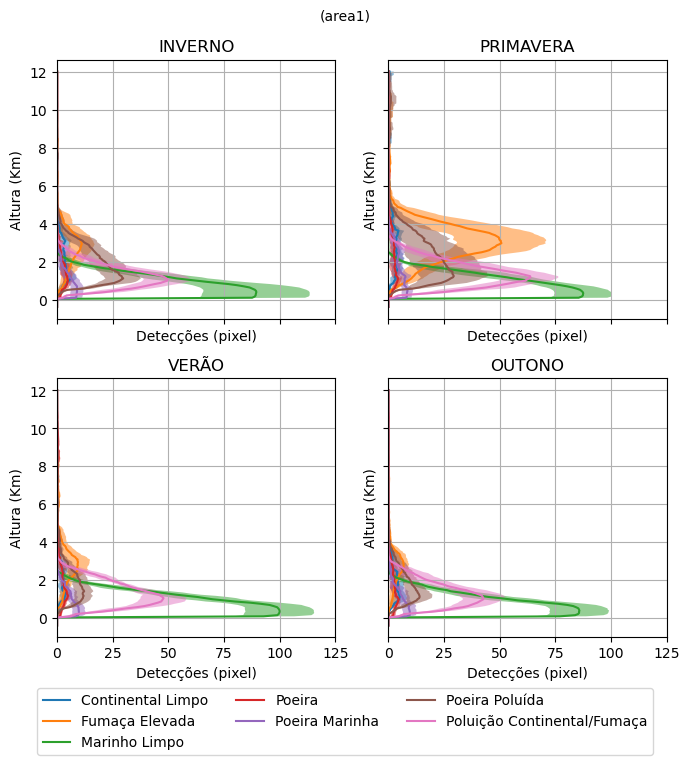


    Média da detecção por tipo de aerossóis troposféricos 



In [54]:
# Perfil vertical das detecções sazonais de cada tipo de aerossol
med_detec = med_periodo['Aerosol_Type'].T.reorder_levels([0,2,1], axis = 1)
fig, axs = plt.subplots(2,2,figsize = (7,7), facecolor='white', sharex=True, sharey=True)
for estacao,ax in zip(estacoes,axs.flatten()):
    for tipo in med_detec[estacao]['mean'].columns:
        ax.plot(med_detec[estacao]['mean'][tipo],alt, label=tipo)
        ax.fill_betweenx(alt, med_detec[estacao]['mean'][tipo]+med_detec[estacao]['std'][tipo],
        med_detec[estacao]['mean'][tipo]-med_detec[estacao]['std'][tipo], alpha=0.5, label='_nolegend_')
    
    ax.set_xlabel('Detecções (pixel)', fontsize= 10)
    ax.set_ylabel('Altura (Km)', fontsize= 10)
    ax.set_title(estacao)
    ax.set_xlim(0,125) 
    # ax.set_xticks(np.arange(0,180, 25)) 
    ax.locator_params(axis = 'x',  min_n_ticks=6)
    ax.set_yticks(np.arange(0,13, 2))
    ax.grid(True)

fig.suptitle(f'(area{area})',fontsize= 10)

lgd = fig.legend(med_detec[estacao]['mean'].columns, loc='lower left', bbox_to_anchor=(0.05, -.095),  ncol=3)

fig.tight_layout()
plt.savefig(fun_district(path)+cidade + f'_media_sazonal_2006_2021_deteccoes_tipo(area{area})',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

print('''
    Média da detecção por tipo de aerossóis troposféricos 
''')

In [55]:
[var for var in variaveis_uni_perfil if 'Extinction_Coefficient' in var]

['Extinction_Coefficient_532_Mean',
 'Extinction_Coefficient_532_Mean_Dust',
 'Extinction_Coefficient_532_Mean_Elevated_Smoke',
 'Extinction_Coefficient_532_Mean_Polluted_Dust']

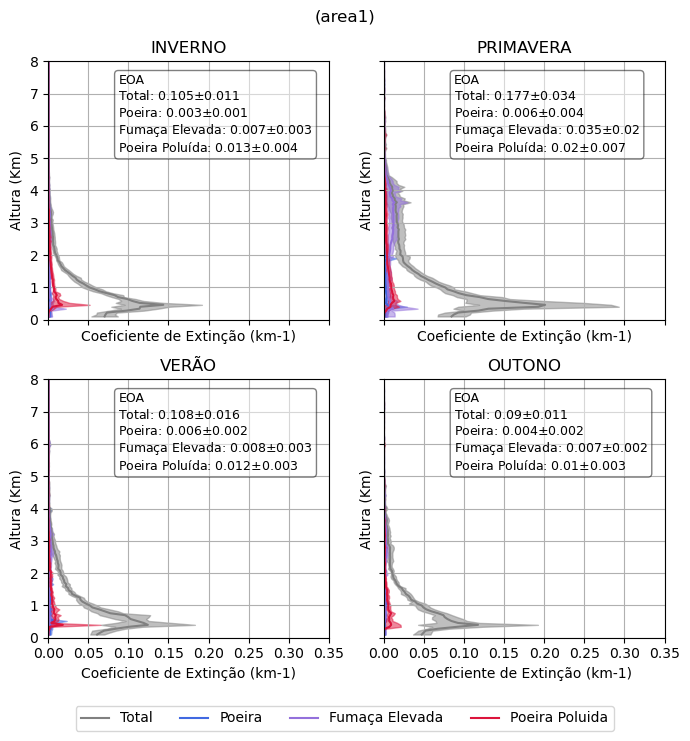


    Valores de coeficiente de extinção para cada estação, sendo o EOA abreviação da Espessura óptica dos aerossois.



In [56]:
# Plotando perfil vertical da média e desvio padrão do coeficiente de extinção
from matplotlib.pyplot import autoscale

variaveis_uni_perfil = {'Extinction_Coefficient_532_Mean':'gray',
                        'Extinction_Coefficient_532_Mean_Dust':'royalblue',
                        'Extinction_Coefficient_532_Mean_Elevated_Smoke':'mediumpurple',
                        'Extinction_Coefficient_532_Mean_Polluted_Dust':'crimson'}
estacoes = ['INVERNO', 'PRIMAVERA', 'VERÃO', 'OUTONO']

leg = ['Total', 'Poeira', 'Fumaça Elevada', 'Poeira Poluida']
alt = SD(file, SDC.READ).select('Altitude_Midpoint').get()[0]

fig, axs = plt.subplots(2, 2, figsize=(7, 7), facecolor='white', sharex=True, sharey=True)
fig.suptitle(f'(area{area})', fontsize=12)
for estacao, ax in zip(estacoes, axs.flatten()):
    for ec in variaveis_uni_perfil.keys():

        ax.plot(med_periodo[ec].T[estacao, 'mean'], alt, variaveis_uni_perfil[ec])
        ax.fill_betweenx(alt, med_periodo[ec].T[estacao, 'mean']+med_periodo[ec].T[estacao, 'std'],
                         med_periodo[ec].T[estacao, 'mean']-med_periodo[ec].T[estacao, 'std'], alpha=0.5, label='_nolegend_', color = variaveis_uni_perfil[ec])

        ax.set_xlabel('Coeficiente de Extinção (km-1)', fontsize=10)
        ax.set_ylabel('Altura (Km)', fontsize=10)
        ax.set_xlim(0,.35)
        ax.set_ylim(0, 8)
        ax.locator_params(axis = 'x',  min_n_ticks=6)
        ax.set_yticks(np.arange(0, 9, 1))
        ax.grid(True)
        ax.set_title(estacao)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    text = ('EOA\nTotal: ' +
            str(med_periodo['AOD_Mean'].T.round(3).loc[:, (estacao, 'mean')][0]) +
             r'$\pm$' + str(med_periodo['AOD_Mean'].T.round(3).loc[:, (estacao, 'std')][0]) +
            '\nPoeira: ' +
            str(med_periodo['AOD_Mean_Dust'].T.round(3).loc[:, (estacao, 'mean')][0]) + 
            r'$\pm$' + str(med_periodo['AOD_Mean_Dust'].T.round(3).loc[:, (estacao, 'std')][0]) +
            '\nFumaça Elevada: ' +
            str(med_periodo['AOD_Mean_Elevated_Smoke'].T.round(3).loc[:, (estacao, 'mean')][0]) + 
            r'$\pm$' + str(med_periodo['AOD_Mean_Elevated_Smoke'].T.round(3).loc[:, (estacao, 'std')][0]) + 
            '\nPoeira Poluída: ' +
            str(med_periodo['AOD_Mean_Polluted_Dust'].T.round(3).loc[:, (estacao, 'mean')][0]) + 
            r'$\pm$' + str(med_periodo['AOD_Mean_Polluted_Dust'].T.round(3).loc[:, (estacao, 'std')][0]))
    
    ax.text(0.25, 0.95, text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)


# plt.legend(med_periodo[ec].T.columns)
lgd = fig.legend(leg, loc='lower left', bbox_to_anchor=(
    0.115, -.05), ncol=4, borderaxespad=0.)
fig.tight_layout()
plt.savefig(fun_district(path)+ cidade + f'_media_sazonal_2011_2016_coef_extincao_espessura(area{area})',
            bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 500)
plt.show()

print('''
    Valores de coeficiente de extinção para cada estação, sendo o EOA abreviação da Espessura óptica dos aerossois.
''')